# Import Required Libraries

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from tqdm import tqdm

In [ ]:
!cp -r /content/drive/MyDrive/fashion_data /content/

In [ ]:
images_path = '/content/fashion_data/images'
data_path = '/content/fashion_data/styles.csv'

# Initial Pre-Processing

In [ ]:
# Read metadata
df = pd.read_csv(data_path, on_bad_lines='skip')

In [ ]:
# Check for missing values
df[df.isnull().any(axis=1)]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
87,56489,Women,Personal Care,Nails,Nail Polish,Bronze,Spring,2017.0,NaN,Streetwear Ash Nail Polish # 31
92,52029,Unisex,Apparel,Topwear,Rain Jacket,Coffee Brown,Summer,2012.0,NaN,Just Natural Unisex Charcoal Rain Jacket
282,5402,Women,Footwear,Shoes,Sports Shoes,Purple,NaN,2011.0,Sports,Kalenji Ekiden 200 Wn Purple 2011
292,55001,Women,Personal Care,Lips,Lipstick,Pink,Spring,2017.0,NaN,Lakme Absolute Lip Last Day Kiss Lip Colour
479,57563,Women,Personal Care,Lips,Lipstick,Brown,Spring,2017.0,NaN,Lotus Herbals Pure Colours Nutty Brown Lipstic...
...,...,...,...,...,...,...,...,...,...,...
43633,56605,Women,Personal Care,Makeup,Kajal and Eyeliner,Black,Spring,2017.0,NaN,Streetwear Black Eye Liner 01
44079,57715,Women,Personal Care,Lips,Lip Gloss,Red,Spring,2017.0,NaN,Lotus Herbals Seduction Sappy Watermelon Lip G...
44224,43120,Men,Personal Care,Fragrance,Perfume and Body Mist,NaN,Spring,2017.0,NaN,GUESS by Marciano Men Eau De Toilette 50 ml
44227,55045,Women,Personal Care,Lips,Lipstick,Purple,Spring,2017.0,NaN,Lakme Enrich Satins Lipstick 461


In [ ]:
# Check for missing values
df.isna().sum()

,0
id,0
gender,0
masterCategory,0
subCategory,0
articleType,0
baseColour,15
season,21
year,1
usage,317
productDisplayName,7


In [ ]:
# Get rid of them because of their low numbers
cleaned = df.dropna()

# EDA with Plotting

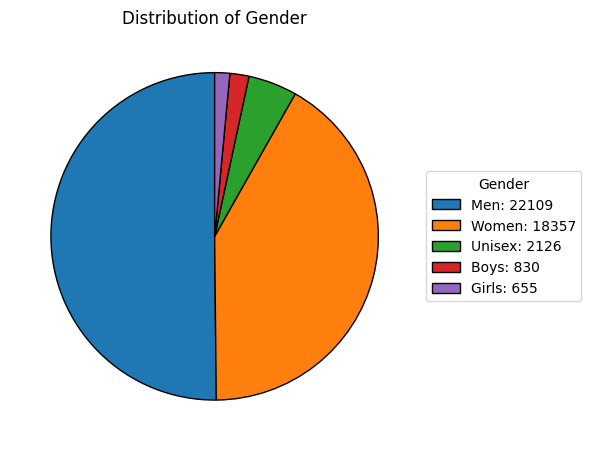

In [ ]:
counts = cleaned['gender'].value_counts()
labels = counts.index.tolist()
sizes  = counts.values.tolist()

fig, ax = plt.subplots(figsize=(6, 6))
wedges, _ = ax.pie(sizes, startangle=90, wedgeprops=dict(edgecolor='k'))

legend_labels = [f"{label}: {cnt}" for label, cnt in zip(labels, sizes)]
ax.legend(
    wedges,
    legend_labels,
    title="Gender",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

ax.set_title('Distribution of Gender')
plt.tight_layout()
plt.show()

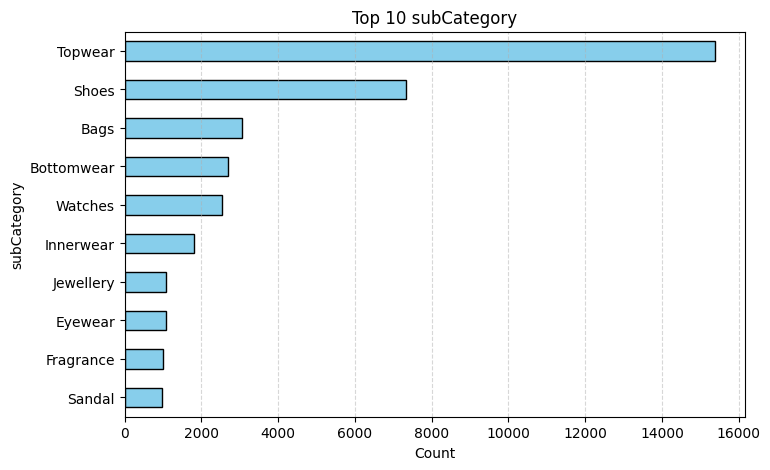

In [ ]:
top10 = cleaned['subCategory'].value_counts().nlargest(10)
plt.figure(figsize=(8,5))
top10.plot(kind='barh', color='skyblue', edgecolor='k')
plt.title('Top 10 subCategory')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

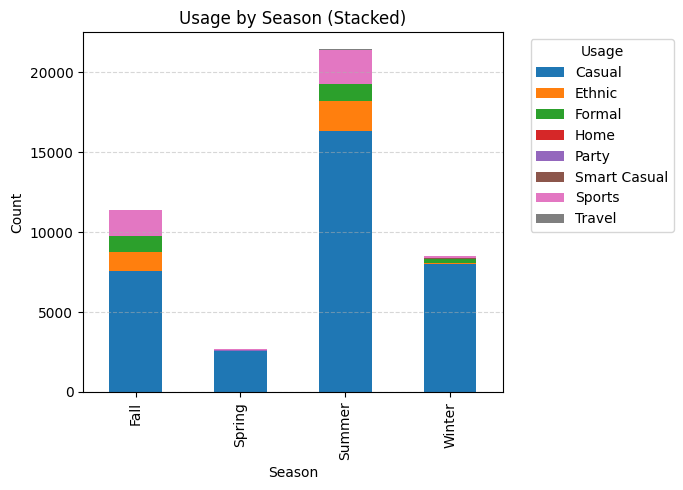

In [ ]:
ct = pd.crosstab(cleaned['season'], cleaned['usage'])
ct.plot(kind='bar', stacked=True, figsize=(7,5))
plt.title('Usage by Season (Stacked)')
plt.xlabel('Season')
plt.ylabel('Count')
plt.legend(title='Usage', bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

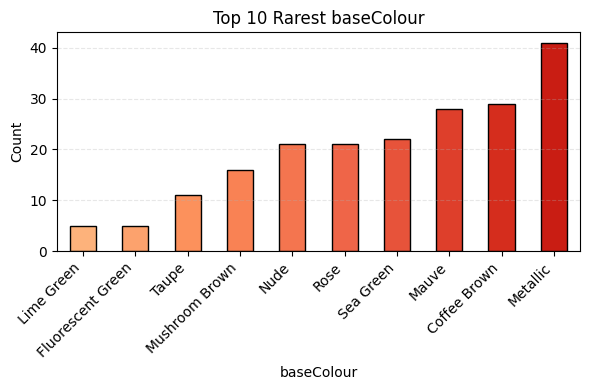

In [ ]:
bottom_bc = cleaned['baseColour'].value_counts().nsmallest(10)
plt.figure(figsize=(6,4))
bottom_bc.plot(
    kind='bar',
    color=plt.cm.OrRd(np.linspace(0.4, 0.8, 10)),
    edgecolor='k'
)
plt.title(f'Top {10} Rarest baseColour')
plt.xlabel('baseColour')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

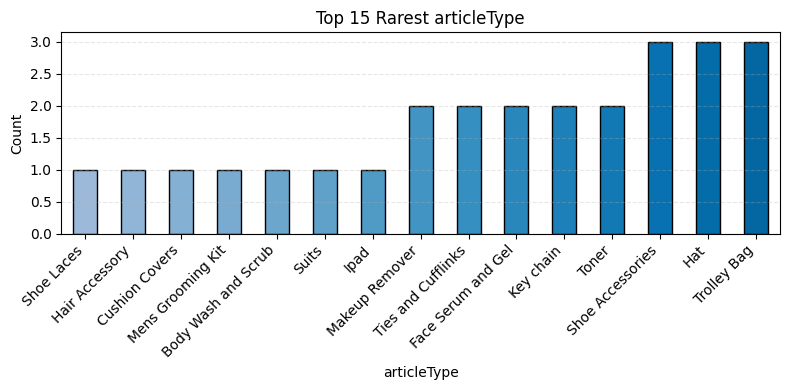

In [ ]:
bottom_at = cleaned['articleType'].value_counts().nsmallest(15)
plt.figure(figsize=(8,4))
bottom_at.plot(
    kind='bar',
    color=plt.cm.PuBu(np.linspace(0.4, 0.8, 15)),
    edgecolor='k'
)
plt.title(f'Top {15} Rarest articleType')
plt.xlabel('articleType')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Helper Functions

In [ ]:
def show_images(df, feature=None, value=None, n=3):
    if feature is not None and value is not None:
        subset = df[df[feature] == value]
        if subset.empty:
            print(f"❌ No rows found where {feature} == '{value}'")
            return
    else:
        subset = df

    subset_ids = subset['id'].astype(str).tolist()
    valid_ids = [
        img_id for img_id in subset_ids
        if os.path.exists(os.path.join(images_path, f"{img_id}.jpg"))
    ]

    if not valid_ids:
        print(f"❌ No images found for {feature} = '{value}'" if feature else "❌ No valid images found in dataset")
        return

    sample_ids = random.sample(valid_ids, min(n, len(valid_ids)))

    for img_id in sample_ids:
        img_path = os.path.join(images_path, f"{img_id}.jpg")
        row = df[df['id'].astype(str) == img_id]

        if row.empty:
            print(f"No metadata found for image ID {img_id}")
            continue

        img = Image.open(img_path).convert("RGB")
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis('off')
        if feature:
            title_info = {k: row.iloc[0][k] for k in [feature, 'id'] if k in row.columns}
            plt.title(f"Image ID: {img_id} | {feature}: {title_info.get(feature)}")
        else:
            plt.title(f"Image ID: {img_id}\n{row.to_dict(orient='records')[0]}")
        plt.show()

In [ ]:
def display_feature(df, columns):
    for col in columns:
        print(f"\n=== {col} (Total unique: {df[col].nunique()}) ===")
        counts = df[col].value_counts().sort_values(ascending=False)
        for value, count in counts.items():
            print(f"{value:<25} {count}")

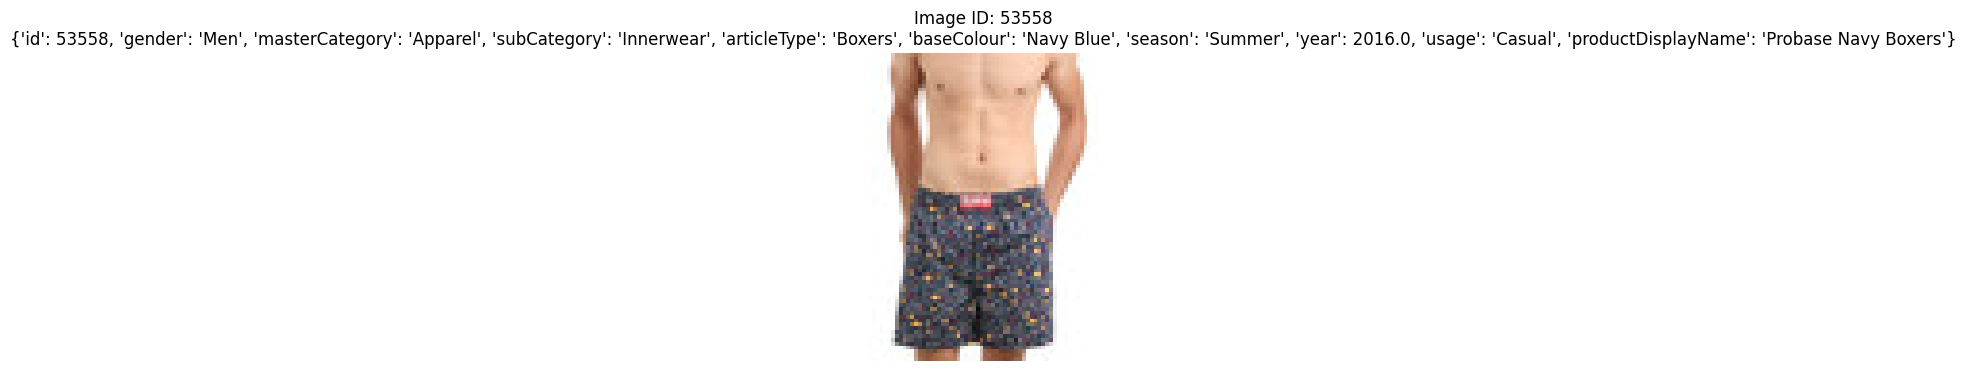

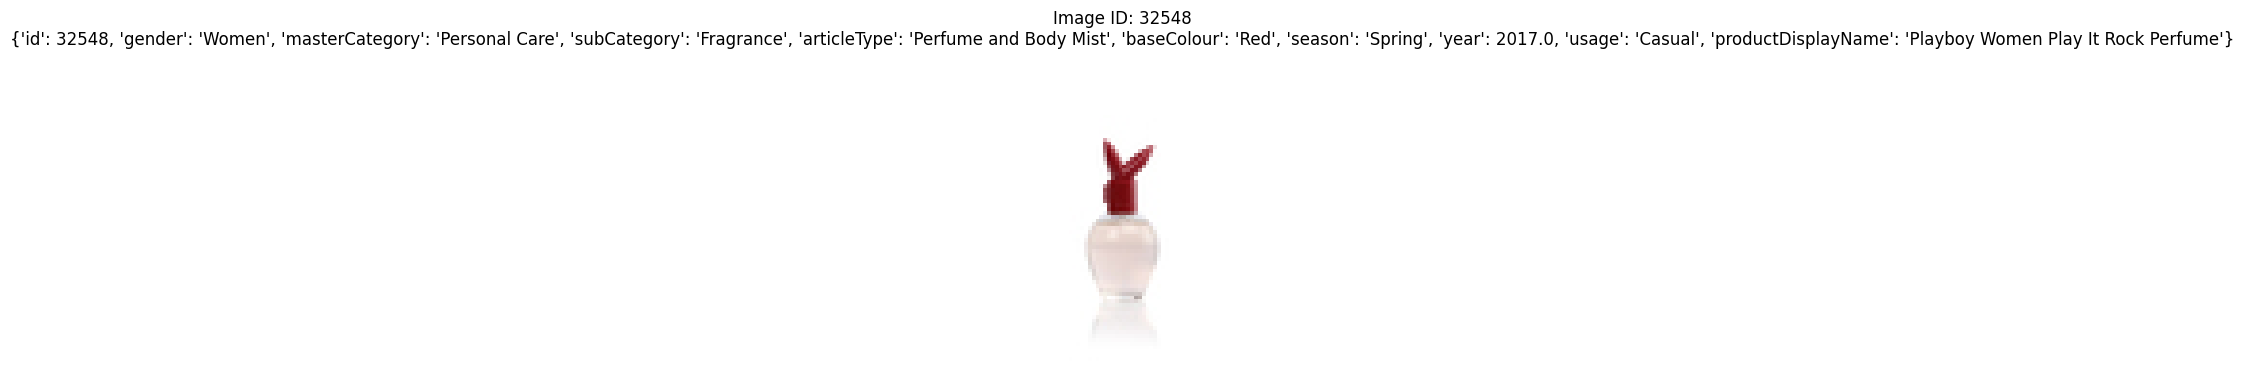

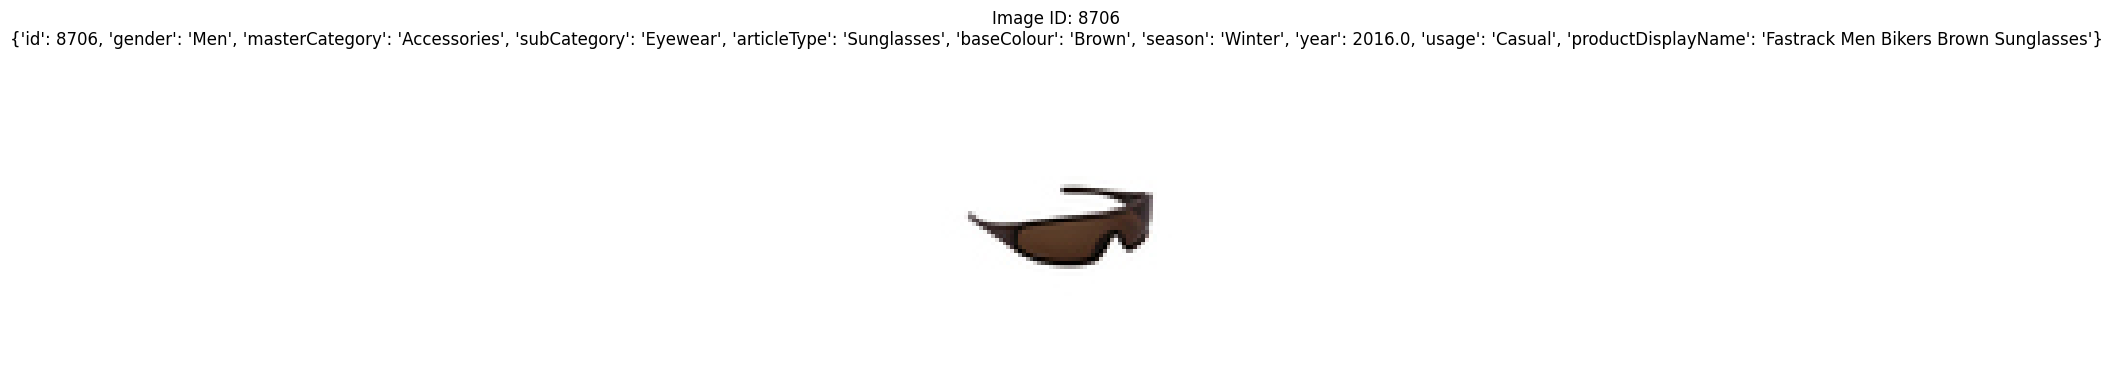

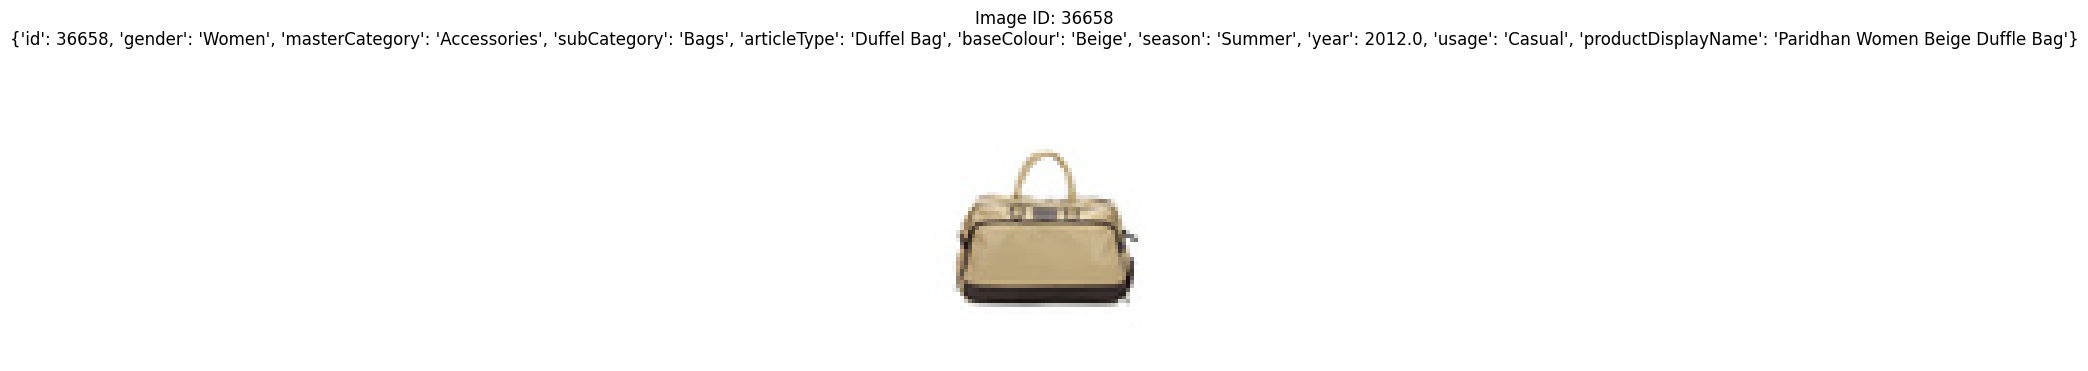

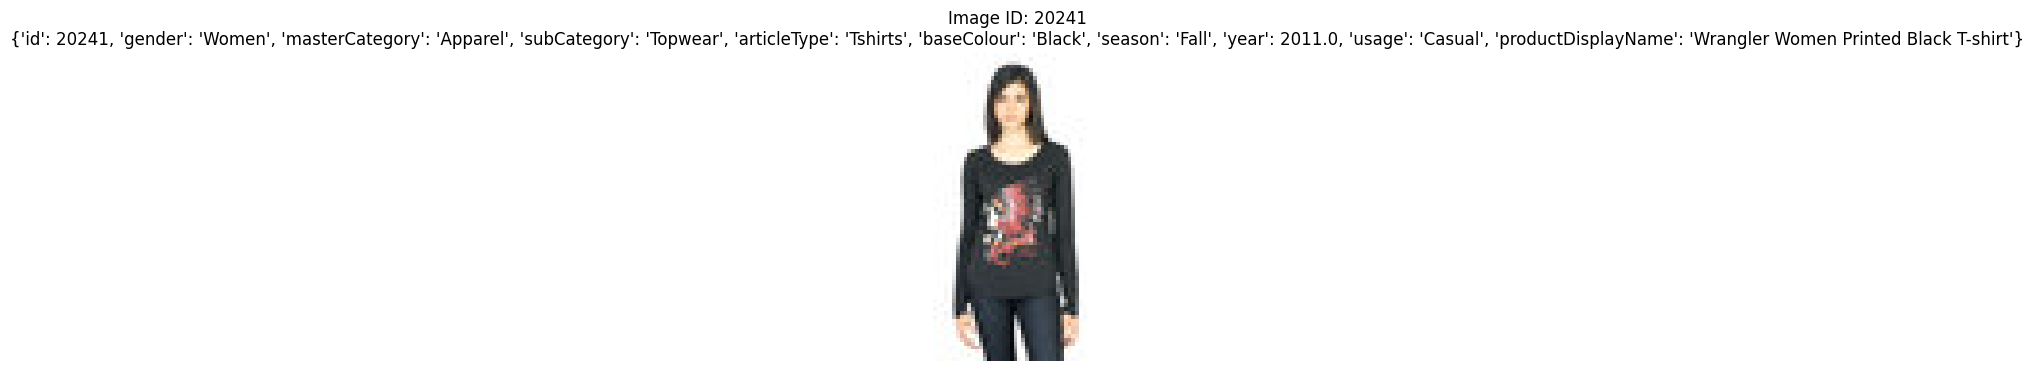

In [ ]:
show_images(cleaned, n=5)

# Feature Engineering

In [ ]:
attributes = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']

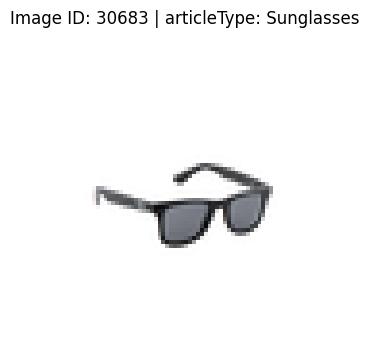

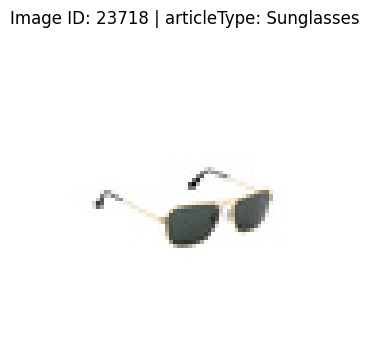

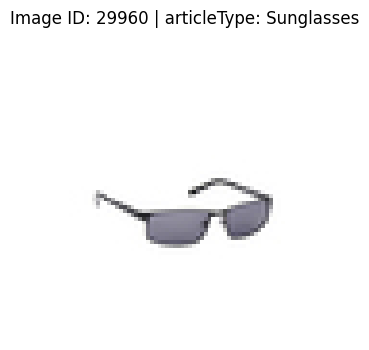

In [ ]:
show_images(cleaned, feature='articleType', value='Sunglasses')

In [ ]:
# Values to remove
junks1 = ['Eyes', 'Free Gifts', 'Perfumes']
junks2 = ["Fragrance Gift Set", "Jewellery Set","Accessory Gift Set", "Free Gifts", "Foundation and Primer", "Fragrance Gift Set",
          "Face Moisturisers", "Lip Liner", "Messenger Bag", "Suspenders", "Compact","Camisoles", "Mufflers", "Highlighter and Blush",
          "Patiala", "Jeggings", "Lounge Shorts", "Stockings", "Salwar", "Eyeshadow", "Churidar", "Tracksuits", "Gloves", "Hair Colour",
          "Bath Robe", "Swimwear", "Waist Pouch", "Face Wash and Cleanser", "Jumpsuit", "Travel Accessory", "Waistcoat", "Sunscreen",
          "Baby Dolls", "Basketballs", "Booties", "Mascara", "Rompers", "Rucksacks", "Concealer", "Water Bottle", "Mask and Peel",
          "Shapewear", "Tights", "Blazers", "Footballs", "Clothing Set", "Salwar and Dupatta", "Headband", "Wristbands", "Lip Care",
          "Rain Jacket", "Umbrellas", "Nail Essentials", "Shrug", "Nehru Jackets", "Lip Plumper", "Face Scrub and Exfoliator", "Eye Cream",
          "Robe", "Lehenga Choli", "Shoe Accessories", "Trolley Bag", "Hat", "Tablet Sleeve", "Lounge Tshirts", "Beauty Accessory",
          "Body Lotion", "Key chain","Ties and Cufflinks", "Makeup Remover", "Face Serum and Gel", "Toner", "Shoe Laces", "Hair Accessory",
          "Cushion Covers", "Mens Grooming Kit", "Body Wash and Scrub", "Rain Trousers", "Suits", "Ipad"]

junks3 = ['Party', 'Travel']

In [ ]:
# articlesType values to merge with other ones
articles = {
    'Tshirts': 'Tshirts Tops',
    'Tops': 'Tshirts Tops',
    'Leggings': 'Short Tight Pants',
    'Capris': 'Short Tight Pants',
    'Shorts': 'Short Tight Pants',
    'Lounge Pants': 'Short Tight Pants',
    'Sports Shoes': 'Sports Footwear',
    'Sports Sandals': 'Sports Footwear',
    'Casual Shoes': 'Casual Footwear',
    'Sandals': 'Casual Footwear',
    'Flip Flops': 'Casual Footwear',
    'Formal Shoes': 'Formal Heeled Footwear',
    'Heels': 'Formal Heeled Footwear',
    'Flats': 'Formal Heeled Footwear',
    'Dresses': 'Dresses',
    'Nightdress': 'Dresses',
    'Night suits': 'Dresses',
    'Sarees': 'Traditional Womenswear',
    'Kurta Sets': 'Traditional Womenswear',
    'Kurtas': 'Traditional Womenswear',
    'Kurtis': 'Traditional Womenswear',
    'Tunics': 'Traditional Womenswear',
    'Scarves': 'Scarves',
    'Stoles': 'Scarves',
    'Dupatta': 'Scarves',
    'Necklace and Chains': 'Bracelet',
    'Bangle': 'Bracelet',
    'Bracelet': 'Bracelet',
    'Briefs': 'Mens Underwear',
    'Innerwear Vests': 'Mens Underwear',
    'Boxers': 'Mens Underwear',
    'Trunk': 'Mens Underwear',
    'Sweatshirts': 'Sweatshirts',
    'Sweaters': 'Sweatshirts',
    'Jackets': 'Sweatshirts',
    'Skirts': 'Skirts Pants',
    'Patiala': 'Skirts Pants',
    'Churidar': 'Skirts Pants',
    'Salwar': 'Skirts Pants',
    'Salwar and Dupatta': 'Skirts Pants'
}

In [ ]:
# baseColour values to merge with other ones
colors = {
    'Charcoal': 'Black',
    'Off White': 'White',
    'Cream': 'White',
    'Skin': 'White',
    'Nude': 'White',
    'Navy Blue': 'Blue',
    'Teal': 'Blue',
    'Turquoise Blue': 'Blue',
    'Red': 'Red',
    'Maroon': 'Red',
    'Burgundy': 'Red',
    'Rust': 'Red',
    'Rose': 'Red',
    'Magenta': 'Red',
    'Sea Green': 'Green',
    'Olive': 'Green',
    'Fluorescent Green': 'Green',
    'Lime Green': 'Green',
    'Mustard': 'Yellow',
    'Gold': 'Yellow',
    'Khaki': 'Yellow',
    'Peach': 'Pink',
    'Lavender': 'Pink',
    'Mauve': 'Pink',
    'Steel': 'Grey',
    'Grey Melange': 'Grey',
    'Coffee Brown': 'Brown',
    'Tan': 'Brown',
    'Taupe': 'Brown',
    'Mushroom Brown': 'Brown',
    'Copper': 'Orange',
    'Bronze': 'Orange',
    'Metallic': 'Silver',
}

In [ ]:
df = cleaned[~(cleaned['subCategory'].isin(junks1) | cleaned['articleType'].isin(junks2) | cleaned['usage'].isin(junks3))].copy()

In [ ]:
df['articleType'] = df['articleType'].map(articles).fillna(df['articleType'])

In [ ]:
df['baseColour'] = df['baseColour'].map(colors).fillna(df['baseColour'])

In [ ]:
df['usage'] = df['usage'].replace('Smart Casual', 'Casual')

In [ ]:
# Apply changes and check the new dataset
display_feature(df, attributes)


=== gender (Total unique: 5) ===
Men                       21743
Women                     17465
Unisex                    1961
Boys                      802
Girls                     627

=== masterCategory (Total unique: 4) ===
Apparel                   20861
Accessories               10875
Footwear                  9195
Personal Care             1667

=== subCategory (Total unique: 26) ===
Topwear                   15285
Shoes                     7321
Bags                      2963
Watches                   2541
Bottomwear                2462
Innerwear                 1758
Eyewear                   1073
Jewellery                 1021
Sandal                    961
Fragrance                 943
Wallets                   925
Flip Flops                913
Belts                     811
Socks                     686
Dress                     443
Saree                     427
Loungewear and Nightwear  392
Lips                      369
Headwear                  283
Nails                   

# Verify and Check Images & Metadata

In [ ]:
img_ids = df['id'].astype(str).tolist()
existings = [img_id for img_id in tqdm(img_ids, desc="Verifying images")
                     if os.path.exists(os.path.join(images_path, f"{img_id}.jpg"))]
metadata = df[df['id'].astype(str).isin(existings)].reset_index(drop=True)
print(f"Original metadata size: {len(cleaned)}")
print(f"Filtered metadata size: {len(metadata)}")

Verifying images: 100%|██████████| 42598/42598 [00:00<00:00, 138106.63it/s]


Original metadata size: 44077
Filtered metadata size: 42594


# Encoding

In [ ]:
label2idx_dict = {}
for a in attributes:
    uniques = metadata[a].unique()
    label2idx_dict[a] = {label: idx for idx, label in enumerate(uniques)}

# Compute number of classes for each attribute
classes = [len(label2idx_dict[a]) for a in attributes]

In [ ]:
# Save the label2idx as json to use it later
with open("label2idx.json", "w") as f:
    json.dump(label2idx_dict, f, indent=4)

# Custom Dataset

In [ ]:
class FashionDataset(Dataset):
    def __init__(self, df, images_dir, attributes, label2idx_dict, transform=None):
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.attributes = attributes
        self.label2idx_dict = label2idx_dict
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = row['id']
        img_path = os.path.join(self.images_dir, f"{img_id}.jpg")
        image = Image.open(img_path).convert('RGB')
        labels = [self.label2idx_dict[attr][row[attr]] for attr in self.attributes]
        labels = torch.tensor(labels, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, labels

# Data Transformations

In [ ]:
TARGET_SIZE = (60, 80)
mean = [0.8540, 0.8365, 0.8305]
std = [0.2300, 0.2450, 0.2495]

train_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Dataset Splits & Sampling

In [ ]:
dataset = FashionDataset(metadata, images_path, attributes, label2idx_dict, transform=train_transforms)
data_size = len(dataset)
train_size = int(0.8 * data_size)
val_size = data_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transforms

In [ ]:
label_counts = Counter()
for i in train_dataset.indices:
    row = dataset.df.loc[i]
    for a in attributes:
        label = (a, row[a])
        label_counts[label] += 1

weights = []
for i in train_dataset.indices:
    row = dataset.df.loc[i]
    sample_weights = []
    for a in attributes:
        freq = label_counts[(a, row[a])]
        sample_weights.append(1.0 / freq)
    weights.append(sum(sample_weights) / len(sample_weights))

weights_tensor = torch.DoubleTensor(weights)
sampler = WeightedRandomSampler(weights_tensor, num_samples=len(weights_tensor), replacement=True)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Models Architecture

In [ ]:
class ResNet50MultiTask(nn.Module):
    def __init__(self, num_classes_list):
        super(ResNet50MultiTask, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.backbone.fc = nn.Identity()
        self.classifiers = nn.ModuleList([nn.Linear(2048, nc) for nc in num_classes_list])
    def forward(self, x):
        feats = self.backbone(x).view(x.size(0), -1)
        return [clf(feats) for clf in self.classifiers]

In [ ]:
class MobileNetV2MultiTask(nn.Module):
    def __init__(self, num_classes_list):
        super().__init__()
        backbone = models.mobilenet_v2(pretrained=True).features
        self.backbone = nn.Sequential(*backbone, nn.AdaptiveAvgPool2d((1,1)))
        self.classifiers = nn.ModuleList([nn.Linear(1280, nc) for nc in num_classes_list])
    def forward(self, x):
        feats = self.backbone(x).view(x.size(0), -1)
        return [clf(feats) for clf in self.classifiers]

In [ ]:
class ResNet18MultiTask(nn.Module):
    def __init__(self, num_classes_list):
        super().__init__()
        backbone = models.resnet18(pretrained=True)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone
        self.classifiers = nn.ModuleList([nn.Linear(in_features, nc) for nc in num_classes_list])
    def forward(self, x):
        feats = self.backbone(x)
        return [clf(feats) for clf in self.classifiers]

# Training Process

In [ ]:
def train_model(model, epochs):
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    task_losses = {a: [] for a in attributes}
    total_losses = []
    model.train()
    for epoch in range(1, epochs+1):
        run_task = {a: 0.0 for a in attributes}
        run_tot = 0.0
        progress = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
        for imgs, labels in progress:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            losses = []
            for i, attr in enumerate(attributes):
                l = criterion(outputs[i], labels[:,i])
                run_task[attr] += l.item()*imgs.size(0)
                losses.append(l)
            tot = sum(losses)
            tot.backward(); optimizer.step()
            run_tot += tot.item()*imgs.size(0)
            progress.set_postfix(total=tot.item())
        ds = len(train_loader.dataset)
        for a in attributes: task_losses[a].append(run_task[a]/ds)
        total_losses.append(run_tot/ds)
        summary = " ".join(f"{a}: {task_losses[a][-1]:.4f}" for a in attributes)
        print(f"Epoch {epoch}/{epochs} | {summary} | Total: {total_losses[-1]:.4f}")
    plt.figure(figsize=(12,8))
    epochs_range = range(1, epochs+1)
    for a in attributes: plt.plot(epochs_range, task_losses[a], label=a)
    plt.plot(epochs_range, total_losses, '--', linewidth=2, label='Total')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss per Task + Total'); plt.legend(); plt.show()
    return model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


Epoch 1/20 | gender: 0.7808 masterCategory: 0.4777 subCategory: 1.2795 articleType: 1.7945 baseColour: 1.8331 season: 0.9963 usage: 0.6351 | Total: 7.7970


Epoch 2/20 | gender: 0.6414 masterCategory: 0.2676 subCategory: 0.6848 articleType: 1.0861 baseColour: 1.4879 season: 0.9097 usage: 0.5055 | Total: 5.5830


Epoch 3/20 | gender: 0.6074 masterCategory: 0.2284 subCategory: 0.5606 articleType: 0.9189 baseColour: 1.4032 season: 0.8865 usage: 0.4751 | Total: 5.0800


Epoch 4/20 | gender: 0.5871 masterCategory: 0.2098 subCategory: 0.4991 articleType: 0.8362 baseColour: 1.3520 season: 0.8712 usage: 0.4585 | Total: 4.8139


Epoch 5/20 | gender: 0.5734 masterCategory: 0.1962 subCategory: 0.4595 articleType: 0.7864 baseColour: 1.3262 season: 0.8618 usage: 0.4486 | Total: 4.6523


Epoch 6/20 | gender: 0.5628 masterCategory: 0.1853 subCategory: 0.4277 articleType: 0.7389 baseColour: 1.3035 season: 0.8538 usage: 0.4371 | Total: 4.5092


Epoch 7/20 | gender: 0.5526 masterCategory: 0.1769 subCategory: 0.4045 articleType: 0.7083 baseColour: 1.2877 season: 0.8502 usage: 0.4320 | Total: 4.4122


Epoch 8/20 | gender: 0.5471 masterCategory: 0.1739 subCategory: 0.3912 articleType: 0.6871 baseColour: 1.2712 season: 0.8438 usage: 0.4273 | Total: 4.3416


Epoch 9/20 | gender: 0.5412 masterCategory: 0.1682 subCategory: 0.3786 articleType: 0.6685 baseColour: 1.2625 season: 0.8400 usage: 0.4211 | Total: 4.2802


Epoch 10/20 | gender: 0.5335 masterCategory: 0.1614 subCategory: 0.3635 articleType: 0.6492 baseColour: 1.2416 season: 0.8354 usage: 0.4186 | Total: 4.2033


Epoch 11/20 | gender: 0.5296 masterCategory: 0.1602 subCategory: 0.3537 articleType: 0.6339 baseColour: 1.2401 season: 0.8302 usage: 0.4133 | Total: 4.1611


Epoch 12/20 | gender: 0.5251 masterCategory: 0.1560 subCategory: 0.3446 articleType: 0.6226 baseColour: 1.2294 season: 0.8264 usage: 0.4099 | Total: 4.1140


Epoch 13/20 | gender: 0.5213 masterCategory: 0.1528 subCategory: 0.3343 articleType: 0.6091 baseColour: 1.2173 season: 0.8246 usage: 0.4062 | Total: 4.0658


Epoch 14/20 | gender: 0.5164 masterCategory: 0.1509 subCategory: 0.3261 articleType: 0.5980 baseColour: 1.2152 season: 0.8234 usage: 0.4036 | Total: 4.0337


Epoch 15/20 | gender: 0.5115 masterCategory: 0.1474 subCategory: 0.3235 articleType: 0.5907 baseColour: 1.2052 season: 0.8189 usage: 0.4020 | Total: 3.9992


Epoch 16/20 | gender: 0.5082 masterCategory: 0.1447 subCategory: 0.3116 articleType: 0.5768 baseColour: 1.2044 season: 0.8173 usage: 0.3986 | Total: 3.9616


Epoch 17/20 | gender: 0.5052 masterCategory: 0.1428 subCategory: 0.3088 articleType: 0.5700 baseColour: 1.1935 season: 0.8137 usage: 0.3948 | Total: 3.9288


Epoch 18/20 | gender: 0.5019 masterCategory: 0.1413 subCategory: 0.3034 articleType: 0.5610 baseColour: 1.1863 season: 0.8106 usage: 0.3928 | Total: 3.8973


Epoch 19/20 | gender: 0.5000 masterCategory: 0.1385 subCategory: 0.2953 articleType: 0.5532 baseColour: 1.1759 season: 0.8097 usage: 0.3917 | Total: 3.8644


Epoch 20/20 | gender: 0.4975 masterCategory: 0.1378 subCategory: 0.2928 articleType: 0.5485 baseColour: 1.1774 season: 0.8076 usage: 0.3889 | Total: 3.8504


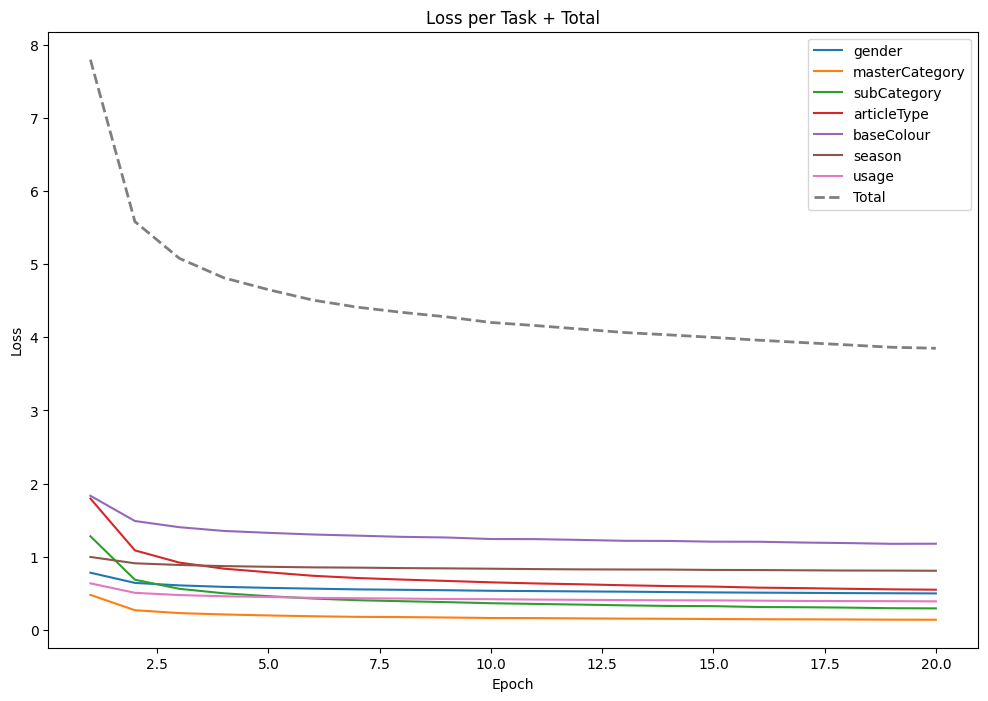

In [ ]:
resnet50_model = ResNet50MultiTask(classes)
trained_resnet50 = train_model(resnet50_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | gender: 0.4576 masterCategory: 0.1200 subCategory: 0.4826 articleType: 0.8067 baseColour: 1.3213 season: 0.7862 usage: 0.3839 | Total: 4.3584


Epoch 2/10 | gender: 0.2930 masterCategory: 0.0278 subCategory: 0.1527 articleType: 0.3366 baseColour: 0.9418 season: 0.6687 usage: 0.2577 | Total: 2.6784


Epoch 3/10 | gender: 0.2474 masterCategory: 0.0163 subCategory: 0.1010 articleType: 0.2482 baseColour: 0.8358 season: 0.6135 usage: 0.2227 | Total: 2.2849


Epoch 4/10 | gender: 0.2123 masterCategory: 0.0115 subCategory: 0.0773 articleType: 0.1974 baseColour: 0.7539 season: 0.5702 usage: 0.1955 | Total: 2.0181


Epoch 5/10 | gender: 0.1902 masterCategory: 0.0082 subCategory: 0.0608 articleType: 0.1641 baseColour: 0.6927 season: 0.5246 usage: 0.1702 | Total: 1.8108


Epoch 6/10 | gender: 0.1644 masterCategory: 0.0056 subCategory: 0.0477 articleType: 0.1329 baseColour: 0.6317 season: 0.4833 usage: 0.1519 | Total: 1.6174


Epoch 7/10 | gender: 0.1453 masterCategory: 0.0051 subCategory: 0.0389 articleType: 0.1097 baseColour: 0.5720 season: 0.4417 usage: 0.1305 | Total: 1.4432


Epoch 8/10 | gender: 0.1283 masterCategory: 0.0054 subCategory: 0.0335 articleType: 0.0956 baseColour: 0.5080 season: 0.4036 usage: 0.1165 | Total: 1.2910


Epoch 9/10 | gender: 0.1116 masterCategory: 0.0044 subCategory: 0.0283 articleType: 0.0787 baseColour: 0.4607 season: 0.3630 usage: 0.0993 | Total: 1.1460


Epoch 10/10 | gender: 0.0994 masterCategory: 0.0038 subCategory: 0.0245 articleType: 0.0678 baseColour: 0.4075 season: 0.3228 usage: 0.0843 | Total: 1.0102


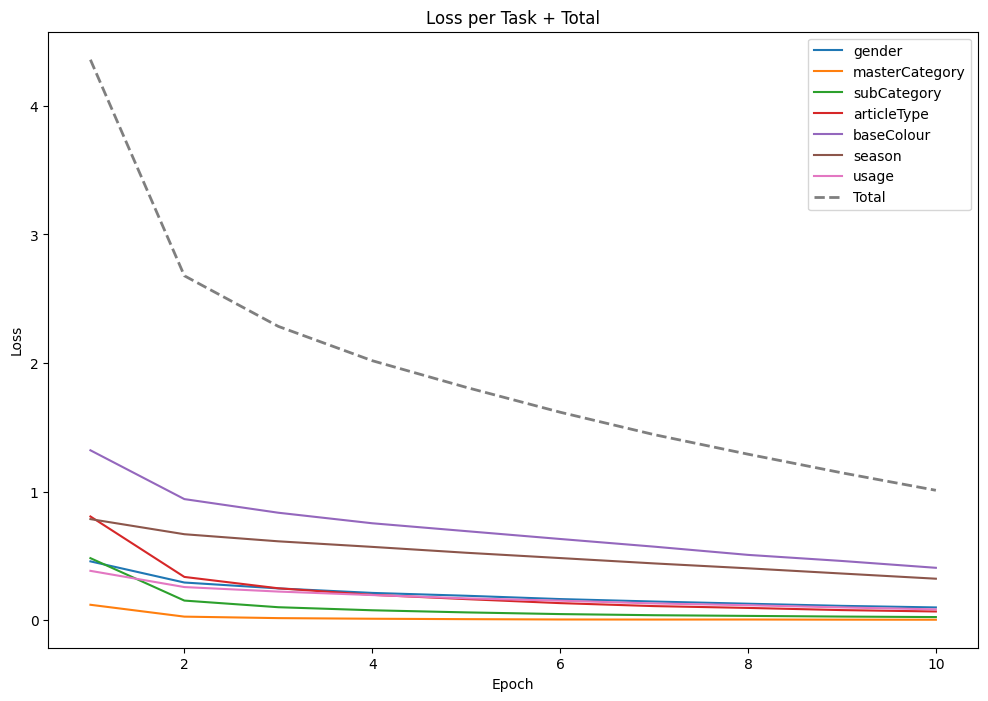

In [ ]:
mobilenetv2_model = MobileNetV2MultiTask(classes)
trained_mobilenetv2 = train_model(mobilenetv2_model, epochs=10)

Epoch 1/5 | gender: 0.4084 masterCategory: 0.1067 subCategory: 0.4130 articleType: 0.7082 baseColour: 1.2300 season: 0.7704 usage: 0.3581 | Total: 3.9949


Epoch 2/5 | gender: 0.2529 masterCategory: 0.0248 subCategory: 0.1256 articleType: 0.2776 baseColour: 0.8731 season: 0.6347 usage: 0.2358 | Total: 2.4245


Epoch 3/5 | gender: 0.1992 masterCategory: 0.0130 subCategory: 0.0789 articleType: 0.1917 baseColour: 0.7349 season: 0.5573 usage: 0.1905 | Total: 1.9654


Epoch 4/5 | gender: 0.1596 masterCategory: 0.0086 subCategory: 0.0535 articleType: 0.1368 baseColour: 0.6153 season: 0.4823 usage: 0.1524 | Total: 1.6086


Epoch 5/5 | gender: 0.1240 masterCategory: 0.0062 subCategory: 0.0369 articleType: 0.0991 baseColour: 0.4983 season: 0.4006 usage: 0.1193 | Total: 1.2843


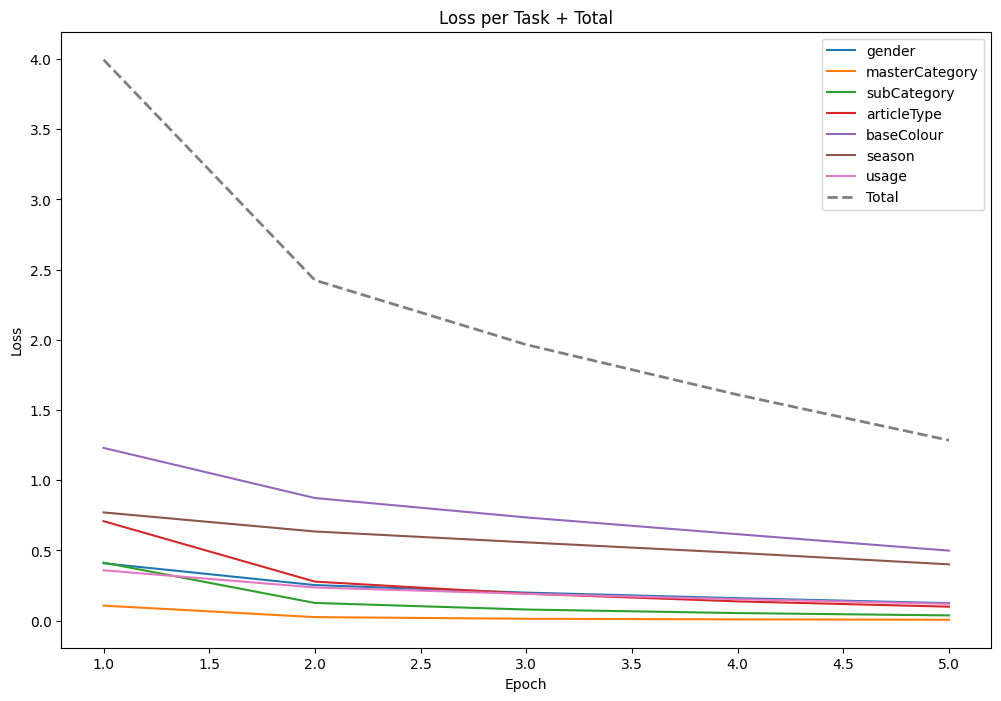

In [ ]:
resnet18_model = ResNet18MultiTask(classes)
trained_resnet18 = train_model(resnet18_model, 5)

# Evaluation

In [ ]:
def evaluate_multitask(model):
    model.eval()
    all_preds = [[] for _ in attributes]
    all_labels = [[] for _ in attributes]

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating", leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            for i, output in enumerate(outputs):
                _, preds = output.max(1)
                all_preds[i].extend(preds.cpu().numpy())
                all_labels[i].extend(labels[:, i].cpu().numpy())

    overall_f1 = 0
    overall_accuracy = 0
    f1_scores_per_attr = []

    for i, attr in enumerate(attributes):
        uniques = sorted(set(all_labels[i]))
        target_names = [list(label2idx_dict[attr].keys())[j] for j in uniques]

        print(f"\nClassification Report for {attr}:")
        report_str = classification_report(
            all_labels[i],
            all_preds[i],
            labels=uniques,
            target_names=target_names,
            zero_division=0,
        )
        print(report_str)

        report_dict = classification_report(
            all_labels[i],
            all_preds[i],
            labels=uniques,
            target_names=target_names,
            output_dict=True,
            zero_division=0,
        )

        f1 = report_dict["weighted avg"]["f1-score"]
        acc = report_dict["accuracy"]

        f1_scores_per_attr.append(f1)
        overall_f1 += f1
        overall_accuracy += acc

    overall_f1 /= len(attributes)
    overall_accuracy /= len(attributes)

    print(f"\nOverall Weighted F1-Score across all attributes: {overall_f1:.4f}")
    print(f"Overall Accuracy across all attributes: {overall_accuracy:.4f}")
    print(f"Each Weighted F1-Score list: {[f'{score:.4f}' for score in f1_scores_per_attr]}")

    return overall_f1, overall_accuracy, f1_scores_per_attr


In [ ]:
of1, a1, fpa1 = evaluate_multitask(trained_resnet50)


Classification Report for gender:
              precision    recall  f1-score   support

         Men       0.82      0.83      0.83      4366
       Women       0.78      0.81      0.79      3453
        Boys       0.58      0.41      0.48       189
       Girls       0.37      0.48      0.41       117
      Unisex       0.55      0.31      0.39       394

    accuracy                           0.78      8519
   macro avg       0.62      0.57      0.58      8519
weighted avg       0.78      0.78      0.78      8519


Classification Report for masterCategory:
               precision    recall  f1-score   support

      Apparel       0.98      0.93      0.95      4186
  Accessories       0.83      0.96      0.89      2136
     Footwear       0.99      0.94      0.97      1877
Personal Care       0.89      0.81      0.85       320

     accuracy                           0.94      8519
    macro avg       0.92      0.91      0.91      8519
 weighted avg       0.94      0.94      0.94  

In [ ]:
of2, a2, fpa2 = evaluate_multitask(trained_mobilenetv2)


Classification Report for gender:
              precision    recall  f1-score   support

         Men       0.92      0.95      0.94      4366
       Women       0.94      0.92      0.93      3453
        Boys       0.82      0.76      0.79       189
       Girls       0.71      0.68      0.69       117
      Unisex       0.67      0.56      0.61       394

    accuracy                           0.92      8519
   macro avg       0.81      0.77      0.79      8519
weighted avg       0.91      0.92      0.91      8519


Classification Report for masterCategory:
               precision    recall  f1-score   support

      Apparel       1.00      1.00      1.00      4186
  Accessories       0.99      0.99      0.99      2136
     Footwear       1.00      1.00      1.00      1877
Personal Care       1.00      0.97      0.99       320

     accuracy                           1.00      8519
    macro avg       1.00      0.99      0.99      8519
 weighted avg       1.00      1.00      1.00  

In [ ]:
of3, a3, fpa3 = evaluate_multitask(trained_resnet18)


Classification Report for gender:
              precision    recall  f1-score   support

         Men       0.94      0.93      0.94      4366
       Women       0.93      0.94      0.93      3453
        Boys       0.80      0.84      0.82       189
       Girls       0.74      0.79      0.77       117
      Unisex       0.65      0.62      0.63       394

    accuracy                           0.92      8519
   macro avg       0.81      0.83      0.82      8519
weighted avg       0.92      0.92      0.92      8519


Classification Report for masterCategory:
               precision    recall  f1-score   support

      Apparel       1.00      1.00      1.00      4186
  Accessories       1.00      0.99      0.99      2136
     Footwear       1.00      1.00      1.00      1877
Personal Care       0.98      0.99      0.99       320

     accuracy                           1.00      8519
    macro avg       0.99      0.99      0.99      8519
 weighted avg       1.00      1.00      1.00  

# Model Comparison

In [ ]:
model_comparison = pd.DataFrame({
    "Model": ["ResNet50", "MobileNetV2", "Resnet18"],
    "Overall F1": [of1, of2, of3],
    "Overall Acc": [a1, a2, a3],
})

for i, attr in enumerate(attributes):
    model_comparison[attr + " F1"] = [fpa1[i], fpa2[i], fpa3[i]]


In [ ]:
print(model_comparison.round(3).to_string(index=False))

      Model  Overall F1  Overall Acc  gender F1  masterCategory F1  subCategory F1  articleType F1  baseColour F1  season F1  usage F1
   ResNet50       0.766        0.773      0.779              0.937           0.880           0.772          0.576      0.584     0.831
MobileNetV2       0.879        0.879      0.913              0.995           0.967           0.916          0.698      0.745     0.916
   Resnet18       0.879        0.880      0.915              0.996           0.969           0.912          0.693      0.752     0.917


# Save Each Model

In [ ]:
torch.save(trained_resnet50.state_dict(), '/content/drive/MyDrive/fashion_model.pth')
print("Model saved successfully!")

Model saved successfully!


# Test On Some Photos

In [ ]:
image_path = '/content/test.jpg'
image = Image.open(image_path).convert('RGB')

# Use the same transformations in training
preprocess = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Preprocess the image
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0).to(DEVICE)

# Perform prediction
with torch.no_grad():
    outputs = trained_resnet18(input_batch)

# Convert predictions to labels
predictions = []
for i, output in enumerate(outputs):
    _, predicted_idx = output.max(1)
    predicted_label = list(label2idx_dict[attributes[i]].keys())[predicted_idx.item()]
    predictions.append((attributes[i], predicted_label))

print("\nPredicted Labels:")
for a, label in predictions:
    print(f"{a}: {label}")


Predicted Labels:
gender: Men
masterCategory: Apparel
subCategory: Topwear
articleType: Tshirts Tops
baseColour: Yellow
season: Summer
usage: Casual

